<a href="https://colab.research.google.com/github/Shj-A/2022_ML_Project/blob/main/CNN_CIFAR10_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torchsummary import summary
import copy

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

# you have to set mini-batch size as a hyperparameter
# batch size : how many samples per batch to load
batch_size = 32

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_data = torchvision.datasets.CIFAR10(
    root = './data/CIFAR10',
    train = True,
    download = True,
    transform = transform
)

test_data = torchvision.datasets.CIFAR10(
    root = './data/CIFAR10',
    train = False,
    download = True,
    transform = transform
)

train_data, valid_data = train_test_split(train_data, test_size=0.2, shuffle=True)
print('# of train data : {}'.format(len(train_data)))
print('# of valid data : {}'.format(len(valid_data)))
print('# of test data : {}'.format(len(test_data)))

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10
Files already downloaded and verified
# of train data : 40000
# of valid data : 10000
# of test data : 10000


In [ ]:
examples = enumerate(train_data)
batch_index, (example_data, example_label) = next(examples)
print(example_data.shape)
print('input image channel : {}'.format(example_data.shape[0]))
print('input image size : {} * {}'.format(example_data.shape[1], example_data.shape[2]))

torch.Size([3, 32, 32])
input image channel : 3
input image size : 32 * 32


#2-1 change the current kernel size

In [ ]:
batch_size = 32

n_epochs = 5
learning_rate = 0.01
loss_function = nn.CrossEntropyLoss()

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding='same')
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding= 'same')
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 8 * 8 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
for i in range(0,3):
    model = CNN()
    print(model)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    train_loss = [] # train loss per epoch
    valid_loss = [] # valid loss per epoch
    
    train_acc = [] # train accuracy per epoch
    valid_acc = [] # valid accuracy per epoch
    
    # update following two variables whenever valid accuracy improves
    best_model = copy.deepcopy(model)
    best_acc = 0
    
    for epoch in range(n_epochs):
        model.train() # set model as training mode(for compute gradient)
        train_total = 0
        train_correct = 0
        epoch_train_loss = 0
        
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            loss = loss_function(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward() # compute gradient
            optimizer.step() # update weight & bias in the model with computed gradient
            
        train_loss.append(epoch_train_loss/len(train_loader))
        train_acc.append(train_correct/train_total)
        
        model.eval() # set model as evaluation mode
        with torch.no_grad():# we don't need to compute gradient during the evaluation process
            valid_total = 0
            valid_correct = 0
            epoch_valid_loss = 0
            for data in valid_loader:
                inputs, labels = data[0], data[1]
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()
                
                loss = loss_function(outputs, labels)
                epoch_valid_loss += loss.item()
            
            valid_loss.append(epoch_valid_loss/len(valid_loader))
            valid_acc.append(valid_correct / valid_total)
            
        print('[{}/{}]'.format(epoch+1, n_epochs))
        print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
        print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))
        
        if valid_correct/valid_total > best_acc:
            print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
            best_acc = valid_correct/valid_total
            best_model = copy.deepcopy(model)
    print("-----------------------------------------------------------------------------------------------------")


CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[1/5]
training loss : 1.749	 training accuracy : 0.354
validation loss : 1.583	 validation accuracy : 0.414
validation accuracy improved 0.00000 ======> 0.41400
[2/5]
training loss : 1.583	 training accuracy : 0.422
validation loss : 1.572	 validation accuracy : 0.424
validation accuracy improved 0.41400 ======> 0.42410
[3/5]
training loss : 1.537	 training accuracy : 0.441
validation loss : 1.606	 validation accuracy : 0.417
[4/5]
training loss : 1.512	 training accuracy : 0.449
validation loss : 1.493	 validation accuracy : 0.466
validation accuracy improved 0.42410 ==

In [ ]:
#kernelsize = 5
class CNN_1(nn.Module):
    def __init__(self):
        super(CNN_1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, padding = 'same')
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 5, padding = 'same')
        self.fc1 = nn.Linear(16 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [ ]:
for i in range(0,3):
    model = CNN_1()
    print(model)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    train_loss = [] # train loss per epoch
    valid_loss = [] # valid loss per epoch
    
    train_acc = [] # train accuracy per epoch
    valid_acc = [] # valid accuracy per epoch
    
    # update following two variables whenever valid accuracy improves
    best_model = copy.deepcopy(model)
    best_acc = 0
    
    for epoch in range(n_epochs):
        model.train() # set model as training mode(for compute gradient)
        train_total = 0
        train_correct = 0
        epoch_train_loss = 0
        
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            loss = loss_function(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward() # compute gradient
            optimizer.step() # update weight & bias in the model with computed gradient
            
        train_loss.append(epoch_train_loss/len(train_loader))
        train_acc.append(train_correct/train_total)
        
        model.eval() # set model as evaluation mode
        with torch.no_grad():# we don't need to compute gradient during the evaluation process
            valid_total = 0
            valid_correct = 0
            epoch_valid_loss = 0
            for data in valid_loader:
                inputs, labels = data[0], data[1]
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()
                
                loss = loss_function(outputs, labels)
                epoch_valid_loss += loss.item()
            
            valid_loss.append(epoch_valid_loss/len(valid_loader))
            valid_acc.append(valid_correct / valid_total)
            
        print('[{}/{}]'.format(epoch+1, n_epochs))
        print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
        print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))
        
        if valid_correct/valid_total > best_acc:
            print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
            best_acc = valid_correct/valid_total
            best_model = copy.deepcopy(model)
    print("-----------------------------------------------------------------------------------------------------")


CNN_1(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[1/5]
training loss : 1.996	 training accuracy : 0.244
validation loss : 1.899	 validation accuracy : 0.285
validation accuracy improved 0.00000 ======> 0.28530
[2/5]
training loss : 1.869	 training accuracy : 0.281
validation loss : 1.922	 validation accuracy : 0.271
[3/5]
training loss : 1.827	 training accuracy : 0.296
validation loss : 2.009	 validation accuracy : 0.260
[4/5]
training loss : 1.787	 training accuracy : 0.310
validation loss : 1.765	 validation accuracy : 0.316
validation accuracy improved 0.28530 ======> 0.31600
[5/5]
training loss : 1.765	 traini

In [ ]:
#kernelsize = 7
class CNN_2(nn.Module):
    def __init__(self):
        super(CNN_2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, padding = 'same')
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 5, padding = 'same')
        self.fc1 = nn.Linear(16 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
for i in range(0,3):
    model = CNN_2()
    print(model)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    train_loss = [] # train loss per epoch
    valid_loss = [] # valid loss per epoch
    
    train_acc = [] # train accuracy per epoch
    valid_acc = [] # valid accuracy per epoch
    
    # update following two variables whenever valid accuracy improves
    best_model = copy.deepcopy(model)
    best_acc = 0
    
    for epoch in range(n_epochs):
        model.train() # set model as training mode(for compute gradient)
        train_total = 0
        train_correct = 0
        epoch_train_loss = 0
        
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            loss = loss_function(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward() # compute gradient
            optimizer.step() # update weight & bias in the model with computed gradient
            
        train_loss.append(epoch_train_loss/len(train_loader))
        train_acc.append(train_correct/train_total)
        
        model.eval() # set model as evaluation mode
        with torch.no_grad():# we don't need to compute gradient during the evaluation process
            valid_total = 0
            valid_correct = 0
            epoch_valid_loss = 0
            for data in valid_loader:
                inputs, labels = data[0], data[1]
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()
                
                loss = loss_function(outputs, labels)
                epoch_valid_loss += loss.item()
            
            valid_loss.append(epoch_valid_loss/len(valid_loader))
            valid_acc.append(valid_correct / valid_total)
            
        print('[{}/{}]'.format(epoch+1, n_epochs))
        print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
        print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))
        
        if valid_correct/valid_total > best_acc:
            print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
            best_acc = valid_correct/valid_total
            best_model = copy.deepcopy(model)
    print("-----------------------------------------------------------------------------------------------------")

CNN_2(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[1/5]
training loss : 2.055	 training accuracy : 0.232
validation loss : 2.011	 validation accuracy : 0.259
validation accuracy improved 0.00000 ======> 0.25870
[2/5]
training loss : 1.935	 training accuracy : 0.277
validation loss : 1.859	 validation accuracy : 0.308
validation accuracy improved 0.25870 ======> 0.30770
[3/5]
training loss : 1.839	 training accuracy : 0.312
validation loss : 1.789	 validation accuracy : 0.336
validation accuracy improved 0.30770 ======> 0.33640
[4/5]
training loss : 1.788	 training accuracy : 0.331
validation loss : 1.811	 validation

#2-2 different pooling layer 

In [ ]:
class CNN_3(nn.Module):
    def __init__(self):
        super(CNN_3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding='same')
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding= 'same')
        self.fc1 = nn.Linear(32 * 32 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 32 * 32 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
for i in range(0,3):
    model = CNN_3()
    print(model)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    train_loss = [] # train loss per epoch
    valid_loss = [] # valid loss per epoch
    
    train_acc = [] # train accuracy per epoch
    valid_acc = [] # valid accuracy per epoch
    
    # update following two variables whenever valid accuracy improves
    best_model = copy.deepcopy(model)
    best_acc = 0
    
    for epoch in range(n_epochs):
        model.train() # set model as training mode(for compute gradient)
        train_total = 0
        train_correct = 0
        epoch_train_loss = 0
        
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            loss = loss_function(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward() # compute gradient
            optimizer.step() # update weight & bias in the model with computed gradient
            
        train_loss.append(epoch_train_loss/len(train_loader))
        train_acc.append(train_correct/train_total)
        
        model.eval() # set model as evaluation mode
        with torch.no_grad():# we don't need to compute gradient during the evaluation process
            valid_total = 0
            valid_correct = 0
            epoch_valid_loss = 0
            for data in valid_loader:
                inputs, labels = data[0], data[1]
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()
                
                loss = loss_function(outputs, labels)
                epoch_valid_loss += loss.item()
            
            valid_loss.append(epoch_valid_loss/len(valid_loader))
            valid_acc.append(valid_correct / valid_total)
            
        print('[{}/{}]'.format(epoch+1, n_epochs))
        print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
        print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))
        
        if valid_correct/valid_total > best_acc:
            print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
            best_acc = valid_correct/valid_total
            best_model = copy.deepcopy(model)
    print("-----------------------------------------------------------------------------------------------------")

CNN_3(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=16384, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[1/5]
training loss : 2.310	 training accuracy : 0.100
validation loss : 2.304	 validation accuracy : 0.100
validation accuracy improved 0.00000 ======> 0.09960
[2/5]
training loss : 2.304	 training accuracy : 0.100
validation loss : 2.304	 validation accuracy : 0.095
[3/5]
training loss : 2.304	 training accuracy : 0.101
validation loss : 2.304	 validation accuracy : 0.101
validation accuracy improved 0.09960 ======> 0.10130
[4/5]
training loss : 2.304	 training accuracy : 0.101
validation loss : 2.304	 validation accuracy : 0.097
[5/5]
training loss : 2.304	 training accuracy : 0.098
validation loss : 2.304	 validation accuracy : 0.095
-------------

#2-3 Avg pooling

In [ ]:
class CNN_4(nn.Module):
    def __init__(self):
        super(CNN_4, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding='same')
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding= 'same')
        self.pool = nn.AvgPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 8 * 8 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
for i in range(0,3):
    model = CNN_4()
    print(model)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    train_loss = [] # train loss per epoch
    valid_loss = [] # valid loss per epoch
    
    train_acc = [] # train accuracy per epoch
    valid_acc = [] # valid accuracy per epoch
    
    # update following two variables whenever valid accuracy improves
    best_model = copy.deepcopy(model)
    best_acc = 0
    
    for epoch in range(n_epochs):
        model.train() # set model as training mode(for compute gradient)
        train_total = 0
        train_correct = 0
        epoch_train_loss = 0
        
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            loss = loss_function(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward() # compute gradient
            optimizer.step() # update weight & bias in the model with computed gradient
            
        train_loss.append(epoch_train_loss/len(train_loader))
        train_acc.append(train_correct/train_total)
        
        model.eval() # set model as evaluation mode
        with torch.no_grad():# we don't need to compute gradient during the evaluation process
            valid_total = 0
            valid_correct = 0
            epoch_valid_loss = 0
            for data in valid_loader:
                inputs, labels = data[0], data[1]
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()
                
                loss = loss_function(outputs, labels)
                epoch_valid_loss += loss.item()
            
            valid_loss.append(epoch_valid_loss/len(valid_loader))
            valid_acc.append(valid_correct / valid_total)
            
        print('[{}/{}]'.format(epoch+1, n_epochs))
        print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
        print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))
        
        if valid_correct/valid_total > best_acc:
            print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
            best_acc = valid_correct/valid_total
            best_model = copy.deepcopy(model)
    print("-----------------------------------------------------------------------------------------------------")


CNN_4(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[1/5]
training loss : 1.730	 training accuracy : 0.357
validation loss : 1.566	 validation accuracy : 0.427
validation accuracy improved 0.00000 ======> 0.42690
[2/5]
training loss : 1.527	 training accuracy : 0.450
validation loss : 1.493	 validation accuracy : 0.456
validation accuracy improved 0.42690 ======> 0.45630
[3/5]
training loss : 1.433	 training accuracy : 0.485
validation loss : 1.453	 validation accuracy : 0.482
validation accuracy improved 0.45630 ======> 0.48190
[4/5]
training loss : 1.361	 training accuracy : 0.519
validation loss : 1.411	 validation accuracy : 0.503
validation ac

#2-4 Change activation function

## Sigmoid

In [ ]:
class CNN_5(nn.Module):
    def __init__(self):
        super(CNN_5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding='same')
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding= 'same')
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.sigmoid(self.conv1(x)))
        x = self.pool(F.sigmoid(self.conv2(x)))
        x = x.view(-1, 8 * 8 * 16)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
for i in range(0,3):
    model = CNN_5()
    print(model)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    train_loss = [] # train loss per epoch
    valid_loss = [] # valid loss per epoch
    
    train_acc = [] # train accuracy per epoch
    valid_acc = [] # valid accuracy per epoch
    
    # update following two variables whenever valid accuracy improves
    best_model = copy.deepcopy(model)
    best_acc = 0
    
    for epoch in range(n_epochs):
        model.train() # set model as training mode(for compute gradient)
        train_total = 0
        train_correct = 0
        epoch_train_loss = 0
        
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            loss = loss_function(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward() # compute gradient
            optimizer.step() # update weight & bias in the model with computed gradient
            
        train_loss.append(epoch_train_loss/len(train_loader))
        train_acc.append(train_correct/train_total)
        
        model.eval() # set model as evaluation mode
        with torch.no_grad():# we don't need to compute gradient during the evaluation process
            valid_total = 0
            valid_correct = 0
            epoch_valid_loss = 0
            for data in valid_loader:
                inputs, labels = data[0], data[1]
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()
                
                loss = loss_function(outputs, labels)
                epoch_valid_loss += loss.item()
            
            valid_loss.append(epoch_valid_loss/len(valid_loader))
            valid_acc.append(valid_correct / valid_total)
            
        print('[{}/{}]'.format(epoch+1, n_epochs))
        print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
        print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))
        
        if valid_correct/valid_total > best_acc:
            print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
            best_acc = valid_correct/valid_total
            best_model = copy.deepcopy(model)
    print("-----------------------------------------------------------------------------------------------------")

CNN_5(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1/5]
training loss : 2.305	 training accuracy : 0.100
validation loss : 2.304	 validation accuracy : 0.097
validation accuracy improved 0.00000 ======> 0.09710
[2/5]
training loss : 2.304	 training accuracy : 0.096
validation loss : 2.305	 validation accuracy : 0.102
validation accuracy improved 0.09710 ======> 0.10220
[3/5]
training loss : 2.304	 training accuracy : 0.098
validation loss : 2.305	 validation accuracy : 0.096
[4/5]
training loss : 2.304	 training accuracy : 0.098
validation loss : 2.304	 validation accuracy : 0.102
[5/5]
training loss : 2.304	 training accuracy : 0.099
validation loss : 2.304	 validation accuracy : 0.101
-----------------------------------------------------------------------------------------------------
CNN_5(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Line

## Tanh

In [ ]:
class CNN_6(nn.Module):
    def __init__(self):
        super(CNN_6, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding='same')
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding= 'same')
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.tanh(self.conv1(x)))
        x = self.pool(F.tanh(self.conv2(x)))
        x = x.view(-1, 8 * 8 * 16)
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
for i in range(0,3):
    model = CNN_6()
    print(model)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    train_loss = [] # train loss per epoch
    valid_loss = [] # valid loss per epoch
    
    train_acc = [] # train accuracy per epoch
    valid_acc = [] # valid accuracy per epoch
    
    # update following two variables whenever valid accuracy improves
    best_model = copy.deepcopy(model)
    best_acc = 0
    
    for epoch in range(n_epochs):
        model.train() # set model as training mode(for compute gradient)
        train_total = 0
        train_correct = 0
        epoch_train_loss = 0
        
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            loss = loss_function(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward() # compute gradient
            optimizer.step() # update weight & bias in the model with computed gradient
            
        train_loss.append(epoch_train_loss/len(train_loader))
        train_acc.append(train_correct/train_total)
        
        model.eval() # set model as evaluation mode
        with torch.no_grad():# we don't need to compute gradient during the evaluation process
            valid_total = 0
            valid_correct = 0
            epoch_valid_loss = 0
            for data in valid_loader:
                inputs, labels = data[0], data[1]
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()
                
                loss = loss_function(outputs, labels)
                epoch_valid_loss += loss.item()
            
            valid_loss.append(epoch_valid_loss/len(valid_loader))
            valid_acc.append(valid_correct / valid_total)
            
        print('[{}/{}]'.format(epoch+1, n_epochs))
        print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
        print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))
        
        if valid_correct/valid_total > best_acc:
            print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
            best_acc = valid_correct/valid_total
            best_model = copy.deepcopy(model)
    print("-----------------------------------------------------------------------------------------------------")

CNN_6(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[1/5]
training loss : 1.813	 training accuracy : 0.340
validation loss : 1.771	 validation accuracy : 0.354
validation accuracy improved 0.00000 ======> 0.35450
[2/5]
training loss : 1.774	 training accuracy : 0.356
validation loss : 1.822	 validation accuracy : 0.334
[3/5]
training loss : 1.762	 training accuracy : 0.364
validation loss : 1.712	 validation accuracy : 0.383
validation accuracy improved 0.35450 ======> 0.38300
[4/5]
training loss : 1.727	 training accuracy : 0.377
validation loss : 1.738	 validation accuracy : 0.389
validation accuracy improved 0.38300 ======> 0.38900
[5/5]
training loss : 1.743	 training accuracy : 0.368
validation loss : 1.724	 validation accuracy : 0.384
-----------------------------------------------------------------------------------------------------
CNN_6(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, 

#2-5 dropout 사용

In [ ]:
class CNN_7(nn.Module):
    def __init__(self):
        super(CNN_7, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding='same')
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding= 'same')
        self.drop = nn.Dropout2d(p=0.25)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.drop(self.pool(F.relu(self.conv1(x))))
        x = self.drop(self.pool(F.relu(self.conv2(x))))
        x = x.view(-1, 8 * 8 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
for i in range(0,3):
    model = CNN_7()
    print(model)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    train_loss = [] # train loss per epoch
    valid_loss = [] # valid loss per epoch
    
    train_acc = [] # train accuracy per epoch
    valid_acc = [] # valid accuracy per epoch
    
    # update following two variables whenever valid accuracy improves
    best_model = copy.deepcopy(model)
    best_acc = 0
    
    for epoch in range(n_epochs):
        model.train() # set model as training mode(for compute gradient)
        train_total = 0
        train_correct = 0
        epoch_train_loss = 0
        
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            loss = loss_function(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward() # compute gradient
            optimizer.step() # update weight & bias in the model with computed gradient
            
        train_loss.append(epoch_train_loss/len(train_loader))
        train_acc.append(train_correct/train_total)
        
        model.eval() # set model as evaluation mode
        with torch.no_grad():# we don't need to compute gradient during the evaluation process
            valid_total = 0
            valid_correct = 0
            epoch_valid_loss = 0
            for data in valid_loader:
                inputs, labels = data[0], data[1]
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()
                
                loss = loss_function(outputs, labels)
                epoch_valid_loss += loss.item()
            
            valid_loss.append(epoch_valid_loss/len(valid_loader))
            valid_acc.append(valid_correct / valid_total)
            
        print('[{}/{}]'.format(epoch+1, n_epochs))
        print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
        print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))
        
        if valid_correct/valid_total > best_acc:
            print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
            best_acc = valid_correct/valid_total
            best_model = copy.deepcopy(model)
    print("-----------------------------------------------------------------------------------------------------")

CNN_7(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (drop): Dropout2d(p=0.25, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[1/5]
training loss : 1.979	 training accuracy : 0.255
validation loss : 1.839	 validation accuracy : 0.325
validation accuracy improved 0.00000 ======> 0.32490
[2/5]
training loss : 1.882	 training accuracy : 0.300
validation loss : 1.802	 validation accuracy : 0.332
validation accuracy improved 0.32490 ======> 0.33180
[3/5]
training loss : 1.846	 training accuracy : 0.314
validation loss : 1.812	 validation accuracy : 0.330
[4/5]
training loss : 1.829	 training accuracy : 0.319
validation loss : 1.722	 validation accuracy : 

#2-6 Change the optimization method

##Adagrad

In [ ]:
for i in range(0,3):
    model = CNN()
    print(model)
    
    optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)
    train_loss = [] # train loss per epoch
    valid_loss = [] # valid loss per epoch
    
    train_acc = [] # train accuracy per epoch
    valid_acc = [] # valid accuracy per epoch
    
    # update following two variables whenever valid accuracy improves
    best_model = copy.deepcopy(model)
    best_acc = 0
    
    for epoch in range(n_epochs):
        model.train() # set model as training mode(for compute gradient)
        train_total = 0
        train_correct = 0
        epoch_train_loss = 0
        
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            loss = loss_function(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward() # compute gradient
            optimizer.step() # update weight & bias in the model with computed gradient
            
        train_loss.append(epoch_train_loss/len(train_loader))
        train_acc.append(train_correct/train_total)
        
        model.eval() # set model as evaluation mode
        with torch.no_grad():# we don't need to compute gradient during the evaluation process
            valid_total = 0
            valid_correct = 0
            epoch_valid_loss = 0
            for data in valid_loader:
                inputs, labels = data[0], data[1]
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()
                
                loss = loss_function(outputs, labels)
                epoch_valid_loss += loss.item()
            
            valid_loss.append(epoch_valid_loss/len(valid_loader))
            valid_acc.append(valid_correct / valid_total)
            
        print('[{}/{}]'.format(epoch+1, n_epochs))
        print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
        print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))
        
        if valid_correct/valid_total > best_acc:
            print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
            best_acc = valid_correct/valid_total
            best_model = copy.deepcopy(model)
    print("-----------------------------------------------------------------------------------------------------")

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[1/5]
training loss : 1.598	 training accuracy : 0.414
validation loss : 1.411	 validation accuracy : 0.491
validation accuracy improved 0.00000 ======> 0.49150
[2/5]
training loss : 1.355	 training accuracy : 0.507
validation loss : 1.330	 validation accuracy : 0.522
validation accuracy improved 0.49150 ======> 0.52160
[3/5]
training loss : 1.275	 training accuracy : 0.540
validation loss : 1.279	 validation accuracy : 0.543
validation accuracy improved 0.52160 ======> 0.54260
[4/5]
training loss : 1.226	 training accuracy : 0.559
validation loss : 1.237	 validation acc

## RMSProp

In [ ]:
for i in range(0,3):
    model = CNN()
    print(model)
    
    optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
    train_loss = [] # train loss per epoch
    valid_loss = [] # valid loss per epoch
    
    train_acc = [] # train accuracy per epoch
    valid_acc = [] # valid accuracy per epoch
    
    # update following two variables whenever valid accuracy improves
    best_model = copy.deepcopy(model)
    best_acc = 0
    
    for epoch in range(n_epochs):
        model.train() # set model as training mode(for compute gradient)
        train_total = 0
        train_correct = 0
        epoch_train_loss = 0
        
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            loss = loss_function(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward() # compute gradient
            optimizer.step() # update weight & bias in the model with computed gradient
            
        train_loss.append(epoch_train_loss/len(train_loader))
        train_acc.append(train_correct/train_total)
        
        model.eval() # set model as evaluation mode
        with torch.no_grad():# we don't need to compute gradient during the evaluation process
            valid_total = 0
            valid_correct = 0
            epoch_valid_loss = 0
            for data in valid_loader:
                inputs, labels = data[0], data[1]
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()
                
                loss = loss_function(outputs, labels)
                epoch_valid_loss += loss.item()
            
            valid_loss.append(epoch_valid_loss/len(valid_loader))
            valid_acc.append(valid_correct / valid_total)
            
        print('[{}/{}]'.format(epoch+1, n_epochs))
        print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
        print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))
        
        if valid_correct/valid_total > best_acc:
            print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
            best_acc = valid_correct/valid_total
            best_model = copy.deepcopy(model)
    print("-----------------------------------------------------------------------------------------------------")

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[1/5]
training loss : 2.103	 training accuracy : 0.341
validation loss : 1.538	 validation accuracy : 0.453
validation accuracy improved 0.00000 ======> 0.45310
[2/5]
training loss : 1.511	 training accuracy : 0.460
validation loss : 1.484	 validation accuracy : 0.475
validation accuracy improved 0.45310 ======> 0.47480
[3/5]
training loss : 1.431	 training accuracy : 0.495
validation loss : 1.491	 validation accuracy : 0.487
validation accuracy improved 0.47480 ======> 0.48690
[4/5]
training loss : 1.377	 training accuracy : 0.518
validation loss : 1.437	 validation acc

## Adadelta

In [ ]:
for i in range(0,3):
    model = CNN()
    print(model)
    
    optimizer = torch.optim.Adadelta(model.parameters(), lr = learning_rate)
    train_loss = [] # train loss per epoch
    valid_loss = [] # valid loss per epoch
    
    train_acc = [] # train accuracy per epoch
    valid_acc = [] # valid accuracy per epoch
    
    # update following two variables whenever valid accuracy improves
    best_model = copy.deepcopy(model)
    best_acc = 0
    
    for epoch in range(n_epochs):
        model.train() # set model as training mode(for compute gradient)
        train_total = 0
        train_correct = 0
        epoch_train_loss = 0
        
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            loss = loss_function(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward() # compute gradient
            optimizer.step() # update weight & bias in the model with computed gradient
            
        train_loss.append(epoch_train_loss/len(train_loader))
        train_acc.append(train_correct/train_total)
        
        model.eval() # set model as evaluation mode
        with torch.no_grad():# we don't need to compute gradient during the evaluation process
            valid_total = 0
            valid_correct = 0
            epoch_valid_loss = 0
            for data in valid_loader:
                inputs, labels = data[0], data[1]
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()
                
                loss = loss_function(outputs, labels)
                epoch_valid_loss += loss.item()
            
            valid_loss.append(epoch_valid_loss/len(valid_loader))
            valid_acc.append(valid_correct / valid_total)
            
        print('[{}/{}]'.format(epoch+1, n_epochs))
        print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
        print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))
        
        if valid_correct/valid_total > best_acc:
            print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
            best_acc = valid_correct/valid_total
            best_model = copy.deepcopy(model)
    print("-----------------------------------------------------------------------------------------------------")

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[1/5]
training loss : 2.298	 training accuracy : 0.162
validation loss : 2.286	 validation accuracy : 0.187
validation accuracy improved 0.00000 ======> 0.18670
[2/5]
training loss : 2.203	 training accuracy : 0.218
validation loss : 2.086	 validation accuracy : 0.252
validation accuracy improved 0.18670 ======> 0.25210
[3/5]
training loss : 2.012	 training accuracy : 0.279
validation loss : 1.945	 validation accuracy : 0.317
validation accuracy improved 0.25210 ======> 0.31650
[4/5]
training loss : 1.889	 training accuracy : 0.327
validation loss : 1.844	 validation acc

#2-7 Xavier weight initialization

In [ ]:
class CNN_8(nn.Module):
    def __init__(self):
        super(CNN_8, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding='same')
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding= 'same')
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 8 * 8 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
for i in range(0,3):
    model = CNN_8()
    print(model)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    train_loss = [] # train loss per epoch
    valid_loss = [] # valid loss per epoch
    
    train_acc = [] # train accuracy per epoch
    valid_acc = [] # valid accuracy per epoch
    
    # update following two variables whenever valid accuracy improves
    best_model = copy.deepcopy(model)
    best_acc = 0
    
    for epoch in range(n_epochs):
        model.train() # set model as training mode(for compute gradient)
        train_total = 0
        train_correct = 0
        epoch_train_loss = 0
        
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            loss = loss_function(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward() # compute gradient
            optimizer.step() # update weight & bias in the model with computed gradient
            
        train_loss.append(epoch_train_loss/len(train_loader))
        train_acc.append(train_correct/train_total)
        
        model.eval() # set model as evaluation mode
        with torch.no_grad():# we don't need to compute gradient during the evaluation process
            valid_total = 0
            valid_correct = 0
            epoch_valid_loss = 0
            for data in valid_loader:
                inputs, labels = data[0], data[1]
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()
                
                loss = loss_function(outputs, labels)
                epoch_valid_loss += loss.item()
            
            valid_loss.append(epoch_valid_loss/len(valid_loader))
            valid_acc.append(valid_correct / valid_total)
            
        print('[{}/{}]'.format(epoch+1, n_epochs))
        print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
        print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))
        
        if valid_correct/valid_total > best_acc:
            print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
            best_acc = valid_correct/valid_total
            best_model = copy.deepcopy(model)
    print("-----------------------------------------------------------------------------------------------------")


CNN_8(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[1/5]
training loss : 1.646	 training accuracy : 0.400
validation loss : 1.547	 validation accuracy : 0.447
validation accuracy improved 0.00000 ======> 0.44690
[2/5]
training loss : 1.471	 training accuracy : 0.471
validation loss : 1.441	 validation accuracy : 0.497
validation accuracy improved 0.44690 ======> 0.49740
[3/5]
training loss : 1.398	 training accuracy : 0.503
validation loss : 1.430	 validation accuracy : 0.509
validation accuracy improved 0.49740 ======> 0.50860
[4/5]
training loss : 1.351	 training accuracy : 0.522
validation loss : 1.459	 validation a

# 2-8 Change learning rate

In [ ]:
learning_rate2 = 0.02

for i in range(0,3):
    model = CNN()
    print(model)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate2)
    train_loss = [] # train loss per epoch
    valid_loss = [] # valid loss per epoch
    
    train_acc = [] # train accuracy per epoch
    valid_acc = [] # valid accuracy per epoch
    
    # update following two variables whenever valid accuracy improves
    best_model = copy.deepcopy(model)
    best_acc = 0
    
    for epoch in range(n_epochs):
        model.train() # set model as training mode(for compute gradient)
        train_total = 0
        train_correct = 0
        epoch_train_loss = 0
        
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            loss = loss_function(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward() # compute gradient
            optimizer.step() # update weight & bias in the model with computed gradient
            
        train_loss.append(epoch_train_loss/len(train_loader))
        train_acc.append(train_correct/train_total)
        
        model.eval() # set model as evaluation mode
        with torch.no_grad():# we don't need to compute gradient during the evaluation process
            valid_total = 0
            valid_correct = 0
            epoch_valid_loss = 0
            for data in valid_loader:
                inputs, labels = data[0], data[1]
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()
                
                loss = loss_function(outputs, labels)
                epoch_valid_loss += loss.item()
            
            valid_loss.append(epoch_valid_loss/len(valid_loader))
            valid_acc.append(valid_correct / valid_total)
            
        print('[{}/{}]'.format(epoch+1, n_epochs))
        print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
        print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))
        
        if valid_correct/valid_total > best_acc:
            print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
            best_acc = valid_correct/valid_total
            best_model = copy.deepcopy(model)
    print("-----------------------------------------------------------------------------------------------------")


CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[1/5]
training loss : 1.994	 training accuracy : 0.253
validation loss : 1.904	 validation accuracy : 0.301
validation accuracy improved 0.00000 ======> 0.30120
[2/5]
training loss : 1.917	 training accuracy : 0.290
validation loss : 1.877	 validation accuracy : 0.308
validation accuracy improved 0.30120 ======> 0.30810
[3/5]
training loss : 1.891	 training accuracy : 0.297
validation loss : 1.887	 validation accuracy : 0.312
validation accuracy improved 0.30810 ======> 0.31230
[4/5]
training loss : 1.888	 training accuracy : 0.301
validation loss : 1.849	 validation acc

##2-8-1 plot

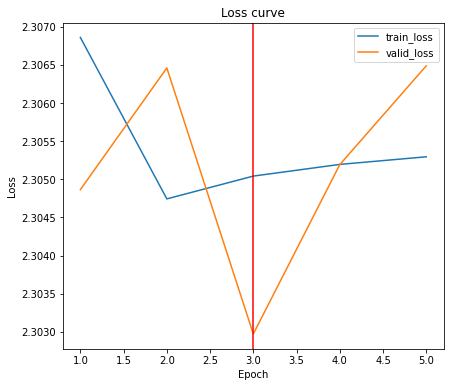

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

np_loss = np.array(valid_loss)
loss_ind_sorted = np.argsort(np_loss)
loss_min_ind = loss_ind_sorted[0]

x = [i+1 for i in range(len(train_loss))]

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x, train_loss, label='train_loss')
plt.plot(x, valid_loss, label='valid_loss')
plt.axvline(loss_min_ind+1, color='red')
plt.legend()

# 2-9 L2 (ridge) regularization method

In [ ]:
from matplotlib.patches import RegularPolygon
for i in range(0,3):
    model = CNN()
    print(model)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 1e-5)
    n_epochs = 5
    train_loss = [] # train loss per epoch
    valid_loss = [] # valid loss per epoch
    
    train_acc = [] # train accuracy per epoch
    valid_acc = [] # valid accuracy per epoch
    
    # update following two variables whenever valid accuracy improves
    best_model = copy.deepcopy(model)
    best_acc = 0
    
    for epoch in range(n_epochs):
        model.train() # set model as training mode(for compute gradient)
        train_total = 0
        train_correct = 0
        epoch_train_loss = 0
        
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            loss = loss_function(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward() # compute gradient
            optimizer.step() # update weight & bias in the model with computed gradient
            
        train_loss.append(epoch_train_loss/len(train_loader))
        train_acc.append(train_correct/train_total)
        
        model.eval() # set model as evaluation mode
        with torch.no_grad():# we don't need to compute gradient during the evaluation process
            valid_total = 0
            valid_correct = 0
            epoch_valid_loss = 0
            for data in valid_loader:
                inputs, labels = data[0], data[1]
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()
                
                loss = loss_function(outputs, labels)
                epoch_valid_loss += loss.item()
            
            valid_loss.append(epoch_valid_loss/len(valid_loader))
            valid_acc.append(valid_correct / valid_total)
            
        print('[{}/{}]'.format(epoch+1, n_epochs))
        print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
        print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))
        
        if valid_correct/valid_total > best_acc:
            print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
            best_acc = valid_correct/valid_total
            best_model = copy.deepcopy(model)
    print("-----------------------------------------------------------------------------------------------------")

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[1/5]
training loss : 1.830	 training accuracy : 0.309
validation loss : 1.708	 validation accuracy : 0.355
validation accuracy improved 0.00000 ======> 0.35470
[2/5]
training loss : 1.676	 training accuracy : 0.367
validation loss : 1.688	 validation accuracy : 0.367
validation accuracy improved 0.35470 ======> 0.36720
[3/5]
training loss : 1.635	 training accuracy : 0.385
validation loss : 1.689	 validation accuracy : 0.376
validation accuracy improved 0.36720 ======> 0.37560
[4/5]
training loss : 1.592	 training accuracy : 0.408
validation loss : 1.636	 validation acc